In [2]:
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import os

# Load variables from .env
load_dotenv()

# Get the MongoDB URI
conn_str = os.getenv("MONGO_SRV")

In [3]:
def load_data():
    # Connect to MongoDB
    client = MongoClient(conn_str)
    db = client["test"]          # Replace with your database name
    collection = db["responses"] 
# Load all documents into a DataFrame
    data = pd.DataFrame(list(collection.find()))
    return data

def calculate_overall_correct(data):
    # Add a column to check if the answer is correct
    data["is_correct"] = (data["selection"] == data["trueLabel"])

    # Group by prolificId and count correct answers
    correct_counts = data[data["is_correct"]].groupby("prolificId").size().reset_index(name="correct_count")

    return correct_counts

In [4]:
data = load_data()

In [5]:
data

,_id,image,selection,trueLabel,trialType,trialId,prolificId,timestamp,__v,rt,timeElapsed
0,680919e0efb3ff05d4bf50a4,/01.png,ball,ball,object_identification,0,674b35aef9b2ae3dcdd26213,2025-04-23 16:48:32.593,0,NaN,NaN
1,680919e4efb3ff05d4bf50a6,/01.png,Right,left,motion_direction,0,674b35aef9b2ae3dcdd26213,2025-04-23 16:48:36.894,0,NaN,NaN
2,680919eeefb3ff05d4bf50a8,/02.png,ball,ball,object_identification,1,674b35aef9b2ae3dcdd26213,2025-04-23 16:48:46.399,0,NaN,NaN
3,680919f1efb3ff05d4bf50aa,/02.png,Right,right,motion_direction,1,674b35aef9b2ae3dcdd26213,2025-04-23 16:48:49.599,0,NaN,NaN
4,680919fcefb3ff05d4bf50ac,/03.png,ball,ball,object_identification,2,674b35aef9b2ae3dcdd26213,2025-04-23 16:49:00.277,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3439,680d301cddd46a6ec1b4d87c,/04.png,left,down,motion_direction,3,unknown,2025-04-26 19:12:28.724,0,1429,6189
3440,680d301eddd46a6ec1b4d87e,/05.png,animal,ball,object_identification,4,unknown,2025-04-26 19:12:30.326,0,1612,7805
3441,680d3020ddd46a6ec1b4d880,/05.png,right,down,motion_direction,4,unknown,2025-04-26 19:12:32.770,0,2396,10205
3442,680d3022ddd46a6ec1b4d882,/06.png,ball,ball,object_identification,5,unknown,2025-04-26 19:12:34.433,0,1711,11922


## Cleaning Data

In [6]:
# Step 1: Drop participants who have ANY NaN 'rt' value
bad_ids = data[data['rt'].isna()]['prolificId'].unique()
clean_data = data[~data['prolificId'].isin(bad_ids)]

In [7]:
# Step 2: Compute accuracy
clean_data['correct'] = (clean_data['selection'] == clean_data['trueLabel']).astype(int)

# Step 3: Remove participants who completed fewer than 70 trials
# Count number of trials per participant
trial_counts = clean_data['prolificId'].value_counts()

# Get participants who completed at least 70 trials
enough_trials_ids = trial_counts[trial_counts >= 70].index

# Filter to keep only participants with enough trials
clean_data = clean_data[clean_data['prolificId'].isin(enough_trials_ids)]

# Step 4: Recompute accuracy after filtering
participant_accuracy = clean_data.groupby('prolificId')['correct'].mean().reset_index()
participant_accuracy.columns = ['prolificId', 'accuracy']

# Step 5: Remove low-performing participants
mean_acc = participant_accuracy['accuracy'].mean()
std_acc = participant_accuracy['accuracy'].std()
cutoff = mean_acc - 2 * std_acc

# Keep participants above cutoff
good_ids = participant_accuracy[participant_accuracy['accuracy'] >= cutoff]['prolificId']

# Final cleaned dataset
final_data = clean_data[clean_data['prolificId'].isin(good_ids)]


/var/folders/mq/p952ryqs1gv79cnvz9f05slr0000gn/T/ipykernel_84584/3835610782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['correct'] = (clean_data['selection'] == clean_data['trueLabel']).astype(int)


In [8]:
final_data.prolificId.unique().size

40

In [9]:
final_data.head()

,_id,image,selection,trueLabel,trialType,trialId,prolificId,timestamp,__v,rt,timeElapsed,correct
87,6809256cf4a04c9d0c168c69,/01.png,ball,ball,object_identification,0,66045b87ffe71e6e521f357d,2025-04-23 17:37:48.572,0,3649,17531,1
88,68092570f4a04c9d0c168c6b,/01.png,right,left,motion_direction,0,66045b87ffe71e6e521f357d,2025-04-23 17:37:52.518,0,4104,21637,0
89,68092574f4a04c9d0c168c6e,/02.png,ball,ball,object_identification,1,66045b87ffe71e6e521f357d,2025-04-23 17:37:56.162,0,3573,25213,1
90,68092575f4a04c9d0c168c70,/02.png,left,right,motion_direction,1,66045b87ffe71e6e521f357d,2025-04-23 17:37:57.851,0,1803,27017,0
91,68092578f4a04c9d0c168c72,/01.png,ball,ball,object_identification,0,60b0ba56f6a2244bbae05690,2025-04-23 17:38:00.745,0,5404,26682,1


In [10]:
object_data = final_data[final_data['trialType'] == 'object_identification'].copy()
motion_data = final_data[final_data['trialType'] == 'motion_direction'].copy()

# Object score

In [11]:
object_data['object_score'] = (object_data['selection'] == object_data['trueLabel']).astype(float)

# Direction score

In [12]:
# Define axis function
def same_axis(pred, true):
    vertical = {'up', 'down'}
    horizontal = {'left', 'right'}
    return (pred in vertical and true in vertical) or (pred in horizontal and true in horizontal)

In [13]:
# Apply scoring
motion_data['motion_score'] = motion_data.apply(
    lambda row: 1.0 if row['selection'] == row['trueLabel'] else
                0.5 if same_axis(row['selection'], row['trueLabel']) else
                0.0,
    axis=1
)

# Total Scores

In [14]:
# Sum scores by participant
object_scores = object_data.groupby('prolificId')['object_score'].sum().reset_index()
motion_scores = motion_data.groupby('prolificId')['motion_score'].sum().reset_index()

# Merge the two
participant_scores = pd.merge(object_scores, motion_scores, on='prolificId')

# Optionally, compute a total score
participant_scores['total_score'] = participant_scores['object_score'] + participant_scores['motion_score']

In [15]:
participant_scores

,prolificId,object_score,motion_score,total_score
0,5acb7b0ae1099600016acdd6,40.0,32.5,72.5
1,5be12624b08fb60001f5680a,40.0,34.5,74.5
2,5cc76f310c352e00161975b4,40.0,35.5,75.5
3,60b0ba56f6a2244bbae05690,40.0,32.5,72.5
4,60f69afe109d7b0fa70bd044,36.0,33.0,69.0
5,647c65c5acb91c89819c7970,40.0,34.0,74.0
6,64b4c078aeb3a03a356ce3b2,39.0,35.5,74.5
7,6522a42f39b5bd8f96735aa9,39.0,32.5,71.5
8,655652e4d1acd4df9b343078,38.0,31.0,69.0
9,65847ecf0896ca006d2c00b7,39.0,37.5,76.5


# Summary

In [ ]:
# Summary statistics
average_object_score = participant_scores['object_score'].mean()/40
average_motion_score = participant_scores['motion_score'].mean()/40
average_total_score = participant_scores['total_score'].mean()/80

# Print out the results
print(f"Average Object Identification Accuracy: {average_object_score:.4f}")
print(f"Average Motion Direction Accuracy: {average_motion_score:.4f}")
print(f"Average Total Accuracy: {average_total_score:.4f}")

Average Object Identification Accuracy: 0.9738
Average Motion Direction Accuracy: 0.8472
Average Total Accuracy: 0.9105


Matplotlib is building the font cache; this may take a moment.


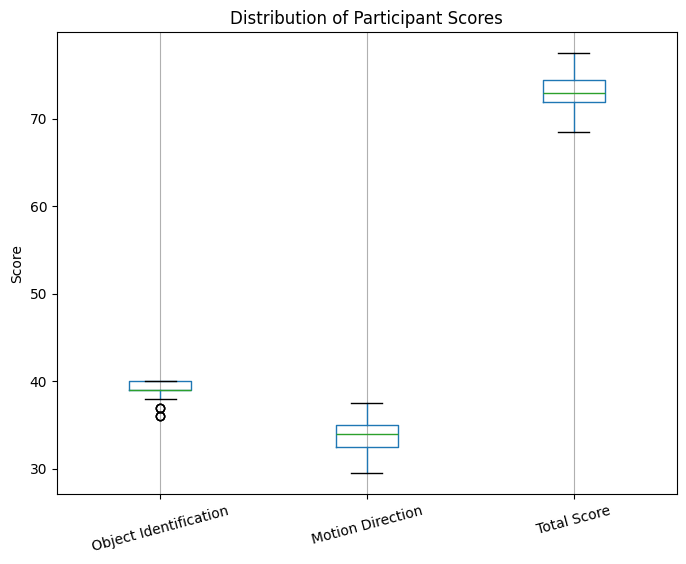

In [16]:
import matplotlib.pyplot as plt

# Prepare data in long format
boxplot_data = participant_scores[['object_score', 'motion_score', 'total_score']]
boxplot_data = boxplot_data.rename(columns={
    'object_score': 'Object Identification',
    'motion_score': 'Motion Direction',
    'total_score': 'Total Score'
})

# Plot
plt.figure(figsize=(8,6))
boxplot_data.boxplot()
plt.title('Distribution of Participant Scores')
plt.ylabel('Score')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


In [19]:
# Compute average scores
summary_df = pd.DataFrame({
    'Score Type': ['Object Identification', 'Motion Direction', 'Total Score'],
    'Average Score': [
        participant_scores['object_score'].mean(),
        participant_scores['motion_score'].mean(),
        participant_scores['total_score'].mean()
    ]
})

summary_df

,Score Type,Average Score
0,Object Identification,38.9500
1,Motion Direction,33.8875
2,Total Score,72.8375


In [21]:
pd.DataFrame({
    'Score Type': ['Object Identification', 'Motion Direction', 'Total Score'],
    'Average Accuracy': [
        participant_scores['object_score'].mean()/40,
        participant_scores['motion_score'].mean()/40,
        participant_scores['total_score'].mean()/80
    ]
})

,Score Type,Average Accuracy
0,Object Identification,0.973750
1,Motion Direction,0.847188
2,Total Score,0.910469


# Older code

In [4]:
data[data['rt'].isna()].prolificId.unique()

array(['674b35aef9b2ae3dcdd26213', 'unknown'], dtype=object)

In [5]:
correct = calculate_overall_correct(data)

In [6]:
correct_by_trial = (
    data[data["is_correct"]]
    .groupby("trialType")
    .size()
    .reset_index(name="correct_count")
)
print(correct_by_trial)

               trialType  correct_count
0       motion_direction           1312
1  object_identification           1670


In [7]:
accuracy_by_trial = (
    data.groupby("trialType")["is_correct"]
    .mean()
    .reset_index(name="accuracy")
)
print(accuracy_by_trial)

               trialType  accuracy
0       motion_direction  0.764123
1  object_identification  0.970366


In [8]:
user_stats = (
    data.groupby("prolificId")
    .agg(
        total_responses=("is_correct", "count"),
        correct_answers=("is_correct", "sum"),
        accuracy=("is_correct", "mean")
    )
    .reset_index()
)
print(user_stats)

                  prolificId  total_responses  correct_answers  accuracy
0   5acb7b0ae1099600016acdd6               80               69  0.862500
1   5be12624b08fb60001f5680a               80               71  0.887500
2   5cc76f310c352e00161975b4               80               74  0.925000
3   60b0ba56f6a2244bbae05690               80               68  0.850000
4   60f69afe109d7b0fa70bd044               80               65  0.812500
5   647c65c5acb91c89819c7970               80               71  0.887500
6   64b4c078aeb3a03a356ce3b2               80               72  0.900000
7   6511f1f1490c9df9f8c7890e               80               64  0.800000
8   6522a42f39b5bd8f96735aa9               80               68  0.850000
9   655652e4d1acd4df9b343078               79               64  0.810127
10  65847ecf0896ca006d2c00b7               80               74  0.925000
11  65a69ce9c8cf8262d34f646a               80               72  0.900000
12  65fade256d70be4d6ea4ecaa               78      

In [9]:
user_stats_by_type = (
    data.groupby(["prolificId", "trialType"])
    .agg(
        total_responses=("is_correct", "count"),
        correct_answers=("is_correct", "sum"),
        accuracy=("is_correct", "mean")
    )
    .reset_index()
)
print(user_stats_by_type)

                  prolificId              trialType  total_responses  \
0   5acb7b0ae1099600016acdd6       motion_direction               40   
1   5acb7b0ae1099600016acdd6  object_identification               40   
2   5be12624b08fb60001f5680a       motion_direction               40   
3   5be12624b08fb60001f5680a  object_identification               40   
4   5cc76f310c352e00161975b4       motion_direction               40   
..                       ...                    ...              ...   
86  67f2b1f27c9c5092a7ac8c84  object_identification               40   
87  67f6784e63c8958eba79d3d9       motion_direction               40   
88  67f6784e63c8958eba79d3d9  object_identification               40   
89                   unknown       motion_direction                2   
90                   unknown  object_identification                3   

    correct_answers  accuracy  
0                29     0.725  
1                40     1.000  
2                31     0.775  
3      

In [12]:
# Remove rows with missing rt
clean_data = data.dropna(subset=["rt"])
clean_data['rt'] = clean_data['rt'].astype(int)

# Now group and compute stats
avg_rt_by_user_type = (
    clean_data.groupby(["prolificId", "trialType"])
    .agg(avg_rt=("rt", "mean"))
    .reset_index()
)

print(avg_rt_by_user_type)


                  prolificId              trialType    avg_rt
0   5acb7b0ae1099600016acdd6       motion_direction  6720.650
1   5acb7b0ae1099600016acdd6  object_identification  3616.925
2   5be12624b08fb60001f5680a       motion_direction  3866.350
3   5be12624b08fb60001f5680a  object_identification  6803.325
4   5cc76f310c352e00161975b4       motion_direction  2788.200
..                       ...                    ...       ...
83  67f2b1f27c9c5092a7ac8c84       motion_direction  4860.975
84  67f2b1f27c9c5092a7ac8c84  object_identification  2233.925
85  67f6784e63c8958eba79d3d9       motion_direction  6011.675
86  67f6784e63c8958eba79d3d9  object_identification  7764.150
87                   unknown  object_identification  2479.000

[88 rows x 3 columns]


/var/folders/mq/p952ryqs1gv79cnvz9f05slr0000gn/T/ipykernel_12742/1311787591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['rt'] = clean_data['rt'].astype(int)


In [13]:
avg_rt_by_user_type

,prolificId,trialType,avg_rt
0,5acb7b0ae1099600016acdd6,motion_direction,6720.650
1,5acb7b0ae1099600016acdd6,object_identification,3616.925
2,5be12624b08fb60001f5680a,motion_direction,3866.350
3,5be12624b08fb60001f5680a,object_identification,6803.325
4,5cc76f310c352e00161975b4,motion_direction,2788.200
...,...,...,...
83,67f2b1f27c9c5092a7ac8c84,motion_direction,4860.975
84,67f2b1f27c9c5092a7ac8c84,object_identification,2233.925
85,67f6784e63c8958eba79d3d9,motion_direction,6011.675
86,67f6784e63c8958eba79d3d9,object_identification,7764.150
